In [27]:
"""
This program runs linear regression on per capita annual 
electricity consumption against annual average
temperature by state for 2021.
Includes scatter plot with line of best fit
and maybe R-score if I get to it.
The source of the electricity consumption data is explained below
"""

'\nThis program runs linear regression on per capita annual \nelectricity consumption against annual average\ntemperature by state for 2021.\nIncludes scatter plot with line of best fit\nand maybe R-score if I get to it.\nThe source of the electricity consumption data is explained below\n'

In [28]:
# Dependencies
import requests
import json
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import DataFrame, Series


import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#API keys
from config import eia_api_key_hugh

This API request is to the EIA and is for electricity consumed based on retail sales data from utilities via EIA's State Energy Data System (SEDS)

API route: State Energy Data System (SEDS)
Frequency: Annual  2021 only
Data type: nothing specified, only "value (required)"
Facet, filtered by Unique Series Identifier (SERIESID):  ESTCP (Electricity, total consumption (i.e. retail sales) (note: ESTCP reports the data in kWh. A similar facet  (facetid: ESTCB) reports the data in Btu.
https://www.eia.gov/opendata/browser/seds

The first section, API call to SEDS creates a .csv file in the same directory as this .ipynb file.  Then, I manually pull the consumption by state data from that .csv, push it into a different spreadsheet called "consumption_per_capita_v_temp" that also contains 2021 temperature and population data by state. There are some print functions at the end of the first section that have no function except to get a glimpse of the quality of the API call & the data


I then divide population into the consumption data to get kWh consumption per capita.  Now I can save a .csv version of this spreadsheet in the same directory


In the second section, I use that second csv file
("consumption_per_capita_v_temp.csv")
to create a pd dataframe called "pcec_v_temp_by_state_2021"
This dataframe is my data source for the linear regression,
which is done in scikit_learn (sklearn) (see dependencies)

The final part is a scatter plot and line of best fit visualization based on a Seaborn(sns) function called:
sns.regplot(x="independent_variable, y="dependent_variable", data= datasource_object)

In [29]:
#Designate base url
base_url = "https://api.eia.gov/v2/seds/data/"

In [30]:
#Note the parameter syntax, including placement of quotes, colons and commas
#The final comma, in the length row, is intentional in order to accomodate
#additional parameters in the future.
#The first parameter is my personal API key for EIA's API.

parameters = {
    "api_key": eia_api_key_hugh,
    "frequency": "annual",
    "data[0]": "value",
    "facets[seriesId][]": ["ESTCP"],
    "start": "2021",
    "end": "2021",
    "offset": "0",
    "length": "5000",
}

In [31]:
# Performing a GET Request and saving the 
# API's response within a variable.
#params is one of the parameters in the response.get method and refers
#to the API parameters, although params is itself a parameter for the response.get method.

response = requests.get(base_url, params = parameters)
response_json = response.json()
print(response.json())

{'response': {'total': 52, 'dateFormat': 'YYYY', 'frequency': 'annual', 'data': [{'period': 2021, 'seriesId': 'ESTCP', 'seriesDescription': 'Electricity total consumption (i.e., retail sales)', 'stateId': 'TN', 'stateDescription': 'Tennessee', 'value': 99621, 'unit': 'Million kilowatthours'}, {'period': 2021, 'seriesId': 'ESTCP', 'seriesDescription': 'Electricity total consumption (i.e., retail sales)', 'stateId': 'DE', 'stateDescription': 'Delaware', 'value': 11480, 'unit': 'Million kilowatthours'}, {'period': 2021, 'seriesId': 'ESTCP', 'seriesDescription': 'Electricity total consumption (i.e., retail sales)', 'stateId': 'GA', 'stateDescription': 'Georgia', 'value': 137364, 'unit': 'Million kilowatthours'}, {'period': 2021, 'seriesId': 'ESTCP', 'seriesDescription': 'Electricity total consumption (i.e., retail sales)', 'stateId': 'IN', 'stateDescription': 'Indiana', 'value': 99740, 'unit': 'Million kilowatthours'}, {'period': 2021, 'seriesId': 'ESTCP', 'seriesDescription': 'Electricity

In [32]:
#I am 'pretty printing' the result with the indent and sort_keys options
print(json.dumps(response_json, indent=4, sort_keys=True))

{
    "apiVersion": "2.1.2",
    "request": {
        "command": "/v2/seds/data/",
        "params": {
            "api_key": "39ZLs9eshRJNS0r0m2m35YXX2cFn36DzdZVgyzvh",
            "data": [
                "value"
            ],
            "end": 2021,
            "facets": {
                "seriesId": [
                    "ESTCP"
                ]
            },
            "frequency": "annual",
            "length": 5000,
            "offset": 0,
            "start": 2021
        }
    },
    "response": {
        "data": [
            {
                "period": 2021,
                "seriesDescription": "Electricity total consumption (i.e., retail sales)",
                "seriesId": "ESTCP",
                "stateDescription": "Tennessee",
                "stateId": "TN",
                "unit": "Million kilowatthours",
                "value": 99621
            },
            {
                "period": 2021,
                "seriesDescription": "Electricity total consumpti

In [33]:
#Now I will take the json object (response_json) and push it into a new Pandas
#dataframe
response_dataframe = pd.DataFrame(response_json["response"]["data"])
response_dataframe.head()

,period,seriesId,seriesDescription,stateId,stateDescription,value,unit
0,2021,ESTCP,"Electricity total consumption (i.e., retail sa...",TN,Tennessee,99621,Million kilowatthours
1,2021,ESTCP,"Electricity total consumption (i.e., retail sa...",DE,Delaware,11480,Million kilowatthours
2,2021,ESTCP,"Electricity total consumption (i.e., retail sa...",GA,Georgia,137364,Million kilowatthours
3,2021,ESTCP,"Electricity total consumption (i.e., retail sa...",IN,Indiana,99740,Million kilowatthours
4,2021,ESTCP,"Electricity total consumption (i.e., retail sa...",AR,Arkansas,48663,Million kilowatthours


In [34]:
# response_dataframe contains total electricity consumption 
#based on retails sales by utilities.
#1 million kWh = 1,000 megawatt hours (MWh) = 1 gigawatt hour (GWh)

In [35]:
#Export dataframe to .csv
response_dataframe.to_csv('consumption_by_state_ESTCP 2021.csv')

In [36]:
#Now import a .csv file into a new dataframe called 
#pcec_v_temp_by_state_2021 
#It will contain the following columns, all data from 2021:
#state 
#estcp (electricity consumption based on retail sales of utilities)
#population 
#kwh_per_capita
#temp

pcec_v_temp_by_state_2021 = pd.read_csv('consumption_per_capita_v_temp.csv')
pcec_v_temp_by_state_2021.head()

,state,estcp,population,kwh_per_capita,temp
0,.Alabama,85585,5049846,16948,62.8
1,.Alaska,5969,734182,8130,26.6
2,.Arizona,81220,7264877,11180,60.3
3,.Arkansas,48663,3028122,16070,60.4
4,.California,247250,39142991,6317,59.4


In [37]:
#Designate the variables
#independent variable:
X = pcec_v_temp_by_state_2021.iloc[:,4].values.reshape(-1,1)
#dependent variable:
y = pcec_v_temp_by_state_2021.iloc[:,3].values.reshape(-1,1)

In [38]:
#Fit the linear regression model
reg = LinearRegression().fit(X,y)

In [39]:
#Get the coefficients
coef = reg.coef_
intercept = reg.intercept_

In [40]:
#Predict using the model
y_pred = reg.predict(X)

In [41]:
#Get mean squared error
mse = mean_squared_error(y, y_pred)

In [42]:
#Get coeffecient of determination
r2 = r2_score(y, y_pred)

In [43]:
#Print the outputs
print("Coefficients: \n",coef)
print("Intercept: \n",intercept)
print("Mean squared error: ", mse)
print("Coefficent of determination (R-squared): ",r2)

Coefficients: 
 [[35.79301889]]
Intercept: 
 [10899.2705898]
Mean squared error:  20351690.364511065
Coefficent of determination (R-squared):  0.004559567307992118


<AxesSubplot:xlabel='temp', ylabel='kwh_per_capita'>

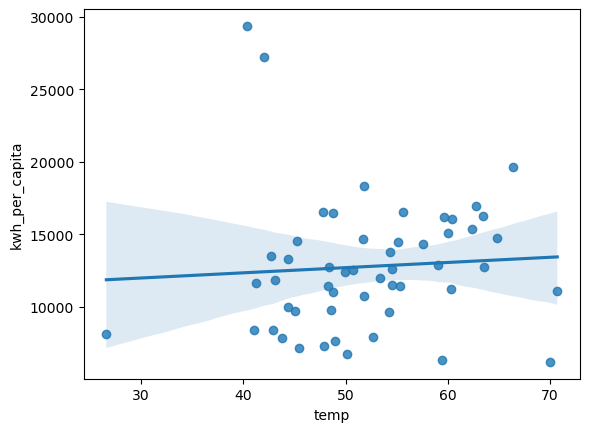

In [45]:
#Trying to do a scatter plot and line of best fit
#using the seaborn as sns library
sns.regplot(x="temp", y="kwh_per_capita", data=pcec_v_temp_by_state_2021)

In [46]:
"""
comments
note the very low R-squared, no discernable correlation 
between temperature and kWh per capita by state in 2021

outlier coordinates:
   temp  kWh/capita   speculated reason           corresp. limitations
HI 70.0,  6,175       high cost($0.30/kWh)        price varies among states
                      less temp variation         less work for HVAC 
                      higher wind speeds          less work for HVAC
                      

FL 70.7, 11,067      lowish cost($0.125/kWh)       price varies among states
                     more temp seasonal variation  more work in summer & winter for HVAC
                     high humidity                 ceteris paribus, more work for HVAC

LA 66.4, 19,628      low cost($0.117/kWh)          price varies among states
                     more seasonal temp variation  more work in summer & winter for HVAC
                     high humidity                 ceteris paribus, more work for HVAC                  

WY 40.4, 27,240      very low cost($0.109)         price varies among states
                     more seasonal temp variation  more work in summer & winter for HVAC

ND 42.0, 29,398      very low cost($0.109)         price varies among states
                     more seasonal temp variation  more work in summer & winter for HVAC

CA 59.4,  6,317      high cost($0.239)             price varies among states
                     geographic temp variation     population not evenly distributed over the state's temperature variation
                     higher proliferation of DERs  a higher proportion of kWh consumed not accounted for in utility-based retail sales data

AK 26.6,  8,130      high cost($.226)              price varies among states
                     less electricity used in building energy - more thermal energy sources for building energy


"""

"\ncomments\nnote the very low R-squared, no discernable correlation \nbetween temperature and kWh per capita by state in 2021\n\noutlier coordinates:\n   temp  kWh/capita   speculated reason           corresp. limitations\nHI 70.0,  6,175       high cost($0.30/kWh)        price varies among states\n                      less temp variation         less work for HVAC \n                      higher wind speeds          less work for HVAC\n                      \n\nFL 70.7, 11,067      lowish cost($0.125/kWh)       price varies among states\n                     more temp seasonal variation  more work in summer & winter for HVAC\n                     high humidity                 ceteris paribus, more work for HVAC\n\nLA 66.4, 19,628      low cost($0.117/kWh)          price varies among states\n                     more seasonal temp variation  more work in summer & winter for HVAC\n                     high humidity                 ceteris paribus, more work for HVAC                  \n